<a href="https://colab.research.google.com/github/tth-97/AI-practice/blob/main/upsample_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from PIL import Image

In [ ]:
from tqdm import tqdm

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cuda


In [ ]:
from torch.nn.modules.upsampling import Upsample
##### AutoEncoder 모델 코드 #####

class Encoder(nn.Module):
    def __init__(self,):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(nn.Conv2d(3, 6, 5, 1, 0),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2, 2),
                                    nn.Conv2d(6, 16, 5, 1, 0),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2, 2),
        )
    def forward(self, input):
        return self.encode(input)


class Decoder(nn.Module):
    def __init__(self, ):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(Upsample(),
                                    nn.Conv2d(16, 6, 5, 1, 4),
                                    nn.ReLU(),
                                    Upsample(),
                                    nn.Conv2d(6, 3, 5, 1, 4),
                                    nn.Tanh(),
        )
    def forward(self, input):
        return self.decode(input)

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, input):
        z = self.encoder(input)
        x_hat = self.decoder(z)
        return z, x_hat

class Upsample(nn.Module):
  def __init__(self):
    super(Upsample, self).__init__()

  def forward(self, input):
    batch_size, channels, height, width = input.shape

    # Define the scale factors for height and width
    scale_factor_h = 2
    scale_factor_w = 2

    input = input.detach().cpu().numpy()
    # Reshape the tensor to a 2D array
    reshaped_tensor = np.reshape(input, (batch_size * channels, height, width))

    # Upsample using np.kron
    upsampled_tensor = np.kron(reshaped_tensor, np.ones((scale_factor_h, scale_factor_w)))

    # Reshape the upsampled tensor back to the original shape
    upsampled_tensor = np.reshape(upsampled_tensor, (batch_size, channels, height * scale_factor_h, width * scale_factor_w))
    upsampled_tensor = torch.Tensor(upsampled_tensor).to(device)

    return upsampled_tensor


In [ ]:
transform = transforms.Compose([transforms.Resize((100, 100)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.Flowers102(root="StanfordCars/", 
                    split='train', 
                    transform=transform,
                    download=True)
test_dataset = torchvision.datasets.Flowers102(root="StanfordCars/", 
                    split='test',
                    transform=transform,
                    download=True)

100%|██████████| 344862509/344862509 [00:09<00:00, 36121497.42it/s]


Extracting StanfordCars/flowers-102/102flowers.tgz to StanfordCars/flowers-102


100%|██████████| 502/502 [00:00<00:00, 540575.25it/s]


100%|██████████| 14989/14989 [00:00<00:00, 39539888.46it/s]


In [ ]:
##### AutoEncoder 학습 코드 #####

batch_size = 255

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

autoencoder = AutoEncoder().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

epochs = 100

autoencoder.train()
train_avg_costs = []

for epoch in range(epochs):
    autoencoder.train()
    avg_cost = 0
    total_batch_num = len(train_dataloader)
    
    for b_x, b_y in train_dataloader:
        b_x = b_x.to(device)
        z, b_x_hat = autoencoder(b_x) # forward propagation
        loss = criterion(b_x_hat, b_x) # get cost
        
        avg_cost += loss / total_batch_num
        optimizer.zero_grad()
        loss.backward() # backward propagation
        optimizer.step() # update parameters
        
    train_avg_costs.append(avg_cost.detach())
    print('Epoch : {} / {}, cost : {}'.format(epoch+1, epochs, avg_cost))

Epoch : 1 / 100, cost : 0.37571847438812256
Epoch : 2 / 100, cost : 0.36900702118873596
Epoch : 3 / 100, cost : 0.36269429326057434
Epoch : 4 / 100, cost : 0.3566640615463257
Epoch : 5 / 100, cost : 0.3509744703769684
Epoch : 6 / 100, cost : 0.345607727766037
Epoch : 7 / 100, cost : 0.3406245708465576
Epoch : 8 / 100, cost : 0.33590683341026306
Epoch : 9 / 100, cost : 0.3315451443195343
Epoch : 10 / 100, cost : 0.3274555206298828
Epoch : 11 / 100, cost : 0.32359936833381653
Epoch : 12 / 100, cost : 0.32008856534957886
Epoch : 13 / 100, cost : 0.31675511598587036
Epoch : 14 / 100, cost : 0.31365975737571716
Epoch : 15 / 100, cost : 0.31079885363578796
Epoch : 16 / 100, cost : 0.3081360459327698
Epoch : 17 / 100, cost : 0.30558717250823975
Epoch : 18 / 100, cost : 0.3032900094985962
Epoch : 19 / 100, cost : 0.30109837651252747
Epoch : 20 / 100, cost : 0.2989811301231384
Epoch : 21 / 100, cost : 0.2970820963382721
Epoch : 22 / 100, cost : 0.29528099298477173
Epoch : 23 / 100, cost : 0.293

In [ ]:
print(train_avg_costs)

[tensor(0.3757, device='cuda:0'), tensor(0.3690, device='cuda:0'), tensor(0.3627, device='cuda:0'), tensor(0.3567, device='cuda:0'), tensor(0.3510, device='cuda:0'), tensor(0.3456, device='cuda:0'), tensor(0.3406, device='cuda:0'), tensor(0.3359, device='cuda:0'), tensor(0.3315, device='cuda:0'), tensor(0.3275, device='cuda:0'), tensor(0.3236, device='cuda:0'), tensor(0.3201, device='cuda:0'), tensor(0.3168, device='cuda:0'), tensor(0.3137, device='cuda:0'), tensor(0.3108, device='cuda:0'), tensor(0.3081, device='cuda:0'), tensor(0.3056, device='cuda:0'), tensor(0.3033, device='cuda:0'), tensor(0.3011, device='cuda:0'), tensor(0.2990, device='cuda:0'), tensor(0.2971, device='cuda:0'), tensor(0.2953, device='cuda:0'), tensor(0.2936, device='cuda:0'), tensor(0.2920, device='cuda:0'), tensor(0.2905, device='cuda:0'), tensor(0.2891, device='cuda:0'), tensor(0.2877, device='cuda:0'), tensor(0.2865, device='cuda:0'), tensor(0.2853, device='cuda:0'), tensor(0.2841, device='cuda:0'), tensor(0.

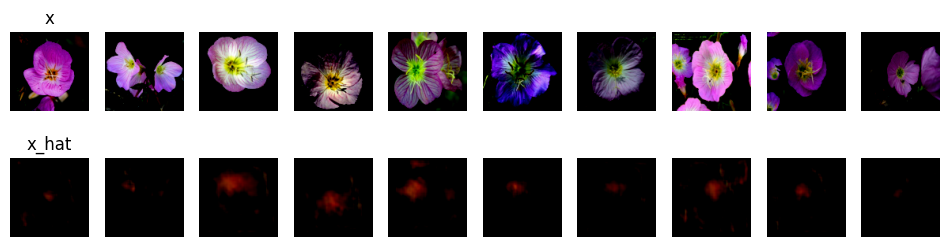

In [ ]:
# autoencoder 학습 결과 확인 #

import matplotlib.pyplot as plt
import numpy as np

autoencoder.eval()
test_samples = torch.zeros((10, 3, 100, 100))
for i in range(10):
  test_samples[i] = test_dataset[2*i][0]
test_samples = test_samples.to(device)
z, test_output = autoencoder(test_samples)

fig, ax = plt.subplots(2, 10, figsize=(12,3))
ax[0][0].set_title('x')
ax[1][0].set_title('x_hat')
for i in range(10):
  ax[0][i].set_axis_off()
  ax[1][i].set_axis_off()
  ax[0][i].imshow(np.transpose(test_samples[i].detach().cpu().numpy(), (1,2,0)))
  ax[1][i].imshow(np.transpose(test_output[i].detach().cpu().numpy(), (1,2,0)))
plt.show()

In [ ]:
##### Classifier 모델 코드 #####

class Classifier(nn.Module):
    def __init__(self, ):
        super(Classifier, self).__init__()
        self.classify = nn.Sequential(nn.Conv2d(16, 32, 3, 1, 0),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2, 2),
                                      nn.Conv2d(32, 64, 3, 1, 0),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2, 2),
                                      nn.Flatten(),
                                      nn.Linear(64*4*4, 512),
                                      nn.ReLU(),
                                      nn.Linear(512, 102),
        )
    def forward(self, input):
        return self.classify(input)

In [ ]:
##### Classifier 학습 코드 #####

classifier = Classifier().to(device)
cls_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    [
        {"params": autoencoder.parameters(), "lr": 0.001},
        {"params": classifier.parameters(), "lr": 0.001},
    ]
)

autoencoder.train()
classifier.train()
total_batch_num = len(train_dataloader)

epochs = 60
classifier_avg_costs = []

for epoch in range(epochs):
  avg_cost = 0

  for b_x, b_y in train_dataloader:
    b_x = b_x.to(device)
    b_y = b_y.to(device)
    z, b_x_hat = autoencoder(b_x)
    logits = classifier(z) # classification
    loss = cls_criterion(logits, b_y) # get cost

    avg_cost += loss / total_batch_num

    optimizer.zero_grad()

    loss.backward() # backward propagation

    optimizer.step() # update param

  classifier_avg_costs.append(avg_cost.detach())
  print('Epoch : {} / {}, cost : {}'.format(epoch+1, epochs, avg_cost))

Epoch : 1 / 60, cost : 4.627128601074219
Epoch : 2 / 60, cost : 4.588231086730957
Epoch : 3 / 60, cost : 4.459476947784424
Epoch : 4 / 60, cost : 4.284054756164551
Epoch : 5 / 60, cost : 4.118893623352051
Epoch : 6 / 60, cost : 4.003152847290039
Epoch : 7 / 60, cost : 3.8980913162231445
Epoch : 8 / 60, cost : 3.83168888092041
Epoch : 9 / 60, cost : 3.7277305126190186
Epoch : 10 / 60, cost : 3.6093385219573975
Epoch : 11 / 60, cost : 3.4859609603881836
Epoch : 12 / 60, cost : 3.3579518795013428
Epoch : 13 / 60, cost : 3.2736246585845947
Epoch : 14 / 60, cost : 3.1362409591674805
Epoch : 15 / 60, cost : 3.015127658843994
Epoch : 16 / 60, cost : 2.9041967391967773
Epoch : 17 / 60, cost : 2.773240327835083
Epoch : 18 / 60, cost : 2.6240265369415283
Epoch : 19 / 60, cost : 2.4725341796875
Epoch : 20 / 60, cost : 2.3242294788360596
Epoch : 21 / 60, cost : 2.2551896572113037
Epoch : 22 / 60, cost : 2.042011022567749
Epoch : 23 / 60, cost : 1.9390861988067627
Epoch : 24 / 60, cost : 1.78885626

In [ ]:
##### Classifier 정확도 측정 코드 #####

correct = 0
total = 0

classifier.eval()
autoencoder.eval()

for b_x, b_y in test_dataloader:
  b_x = b_x.to(device)
  b_y = b_y.to(device)
  with torch.no_grad():
    z, b_x_hat = autoencoder(b_x)
    logits = classifier(z)
  
  predicts = torch.argmax(logits, dim=1)

  total += len(b_y)
  correct += (predicts == b_y).sum().item()

print(f'Accuracy of the netwark on test images: {100 * correct / total} %')

Accuracy of the netwark on test images: 13.20539925191088 %
